## ThinkDSP

This notebook contains code examples from Chapter 3: Non-periodic signals

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

C:\Users\Max\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Max\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Max\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


### Chirp

Make a linear chirp from A3 to A5.

In [3]:
from thinkdsp import Chirp

signal = Chirp(start=220, end=880)
wave1 = signal.make_wave(duration=2)
wave1.make_audio()

Here's what the waveform looks like near the beginning.

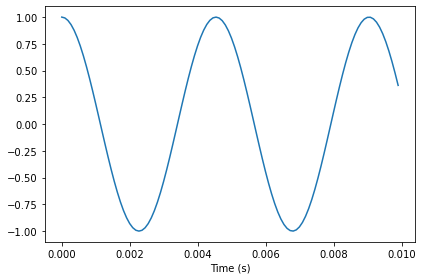

In [4]:
wave1.segment(start=0, duration=0.01).plot()
decorate(xlabel='Time (s)')

And near the end.

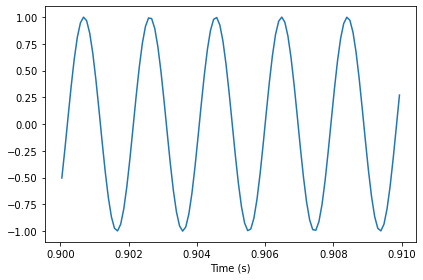

In [5]:
wave1.segment(start=0.9, duration=0.01).plot()
decorate(xlabel='Time (s)')

Here's an exponential chirp with the same frequency range and duration.

In [6]:
from thinkdsp import ExpoChirp

signal = ExpoChirp(start=220, end=880)
wave2 = signal.make_wave(duration=2)
wave2.make_audio()

## Leakage

Spectral leakage is when some of the energy at one frequency appears at another frequency (usually nearby).

Let's look at the effect of leakage on a sine signal (which only contains one frequency component).

In [7]:
from thinkdsp import SinSignal

signal = SinSignal(freq=440)

If the duration is an integer multiple of the period, the beginning and end of the segment line up, and we get minimal leakage.

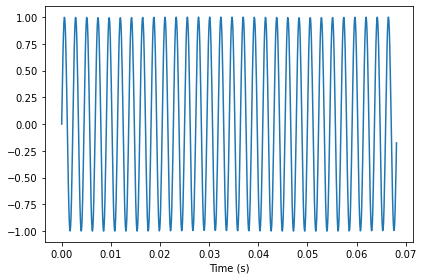

In [8]:
duration = signal.period * 30
wave = signal.make_wave(duration)
wave.plot()
decorate(xlabel='Time (s)')

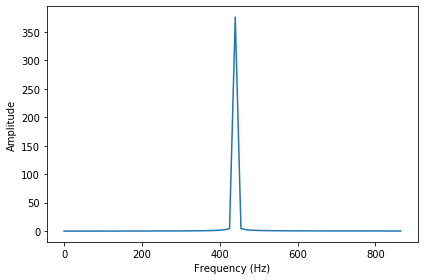

In [9]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

If the duration is not a multiple of a period, the leakage is pretty bad.

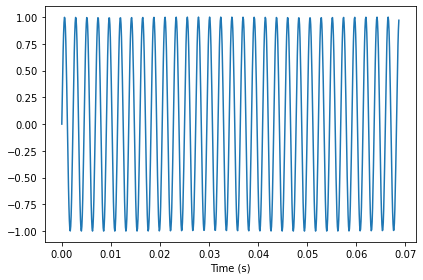

In [9]:
duration = signal.period * 30.25
wave = signal.make_wave(duration)
wave.plot()
decorate(xlabel='Time (s)')

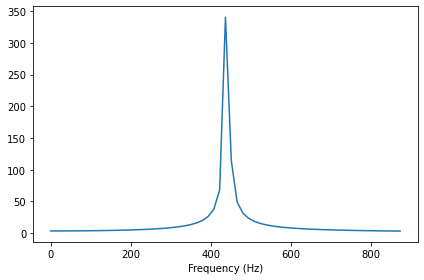

In [10]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

Windowing helps (but notice that it reduces the total energy).

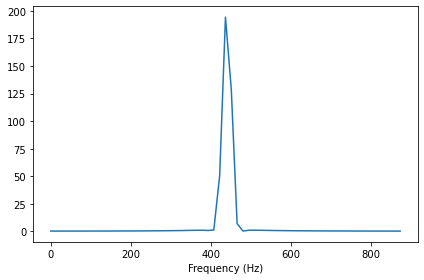

In [11]:
wave.hamming()
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

## Spectrogram

If you blindly compute the DFT of a non-periodic segment, you get "motion blur".

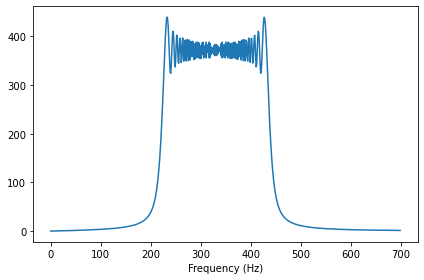

In [12]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1)
spectrum = wave.make_spectrum()
spectrum.plot(high=700)
decorate(xlabel='Frequency (Hz)')

A spectrogram is a visualization of a short-time DFT that lets you see how the spectrum varies over time.

In [15]:
def plot_spectrogram(wave, seg_length):
    """
    """
    spectrogram = wave.make_spectrogram(seg_length)
    print('Time resolution (s)', spectrogram.time_res)
    print('Frequency resolution (Hz)', spectrogram.freq_res)
    spectrogram.plot(high=700)
    decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

Time resolution (s) 0.046439909297052155
Frequency resolution (Hz) 21.533203125


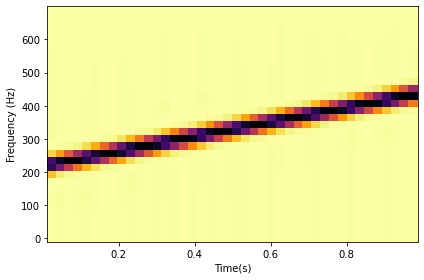

In [16]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1, framerate=11025)
plot_spectrogram(wave, 512)

If you increase the segment length, you get better frequency resolution, worse time resolution.

Time resolution (s) 0.09287981859410431
Frequency resolution (Hz) 10.7666015625


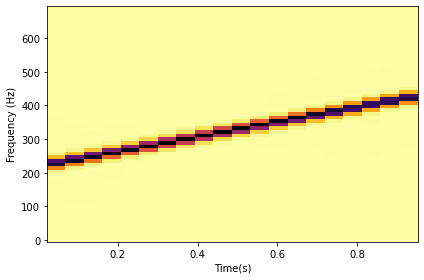

In [17]:
plot_spectrogram(wave, 1024)

If you decrease the segment length, you get better time resolution, worse frequency resolution.

Time resolution (s) 0.023219954648526078
Frequency resolution (Hz) 43.06640625


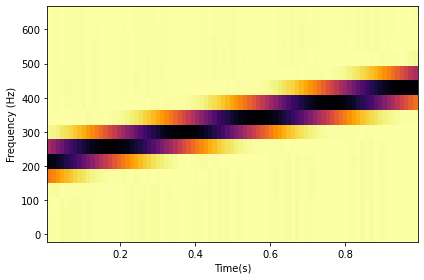

In [18]:
plot_spectrogram(wave, 256)

In [19]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=128, max=4096, value=100, step=128)
interact(plot_spectrogram, wave=fixed(wave), seg_length=slider);

interactive(children=(IntSlider(value=128, description='seg_length', max=4096, min=128, step=128), Output()), …

## Spectrum of a chirp

The following interaction lets you customize the Eye of Sauron as you vary the start and end frequency of the chirp.

In [20]:
def eye_of_sauron(start, end):
    """Plots the spectrum of a chirp.
    
    start: initial frequency
    end: final frequency
    """
    signal =  Chirp(start=start, end=end)
    wave = signal.make_wave(duration=0.5)
    spectrum = wave.make_spectrum()
    
    spectrum.plot(high=1200)
    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

In [21]:
slider1 = widgets.FloatSlider(min=100, max=1000, value=100, step=50)
slider2 = widgets.FloatSlider(min=100, max=1000, value=200, step=50)
interact(eye_of_sauron, start=slider1, end=slider2);

interactive(children=(FloatSlider(value=100.0, description='start', max=1000.0, min=100.0, step=50.0), FloatSl…

# EX 3.2

In [37]:
from thinkdsp import Chirp, SawtoothSignal

class SawtoothChirp(Chirp):
    def __init__(self, start=440, end=880, amp=1.0):
        self.start = start
        self.end = end
        self.amp = amp
    
    def evaluate(self, ts):
        def interpolate(ts, f0, f1):
            t0, t1 = ts[0], ts[-1]
            return f0 + (f1 - f0) * (ts - t0) / (t1 - t0)

        # compute the frequencies
        ts = np.asarray(ts)
        freqs = interpolate(ts, self.start, self.end)

        # compute the time intervals
        dts = np.diff(ts, append=ts[-1])

        # compute the changes in cycles
        dcycles = freqs * dts
        dcycles = np.roll(dcycles, 1)

        # compute phase
        cycles = np.cumsum(dcycles)

        # compute the amplitudes
        frac, _ = np.modf(cycles)
        unbiased = frac - np.mean(frac)
        ys = self.amp * unbiased / np.max(np.abs(unbiased))
        return ys

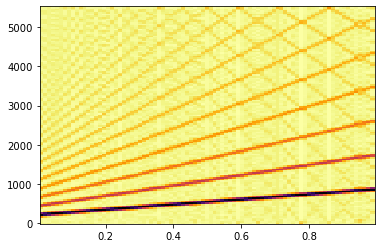

In [40]:
mychirp = SawtoothChirp(start=220, end=880, amp=1.0)
mywave = mychirp.make_wave()
myspectrogram = mywave.make_spectrogram(256)
myspectrogram.plot()

# Ex 3.3

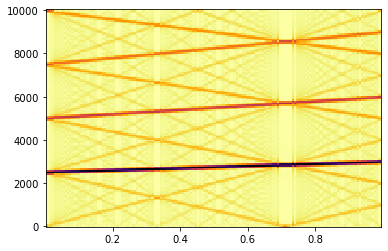

In [41]:
mychirp = SawtoothChirp(start=2500, end=3000, amp=1.0)
mywave = mychirp.make_wave(duration=1, start=0, framerate=20000)
myspectrogram = mywave.make_spectrogram(256)
myspectrogram.plot()

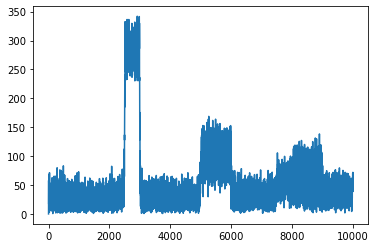

In [42]:
myspectrum = mywave.make_spectrum()
myspectrum.plot()

# Ex 3.4

In [50]:
class TromboneGliss(Chirp):
    def __init__(self, start=440, end=880, amp=1.0):
        self.start = start
        self.end = end
        self.amp = amp
    
    def evaluate(self, ts):        
        def interpolate(ts, f0, f1):
            l = len(ts)
            t0, t1 = ts[0], ts[-1]
            middle = ts[int(l/2)]
            return (ts < middle)*(f0 + (f1 - f0) * (ts - t0) / (middle - t0)) + (ts >= middle)*(f1 + (f0 - f1) * (ts - middle) / (t1 - middle))

        # compute the frequencies
        ts = np.asarray(ts)
        freqs = interpolate(ts, self.start, self.end)

        # compute the time intervals
        dts = np.diff(ts, append=ts[-1])

        # compute the changes in pahse
        dphis = 2 * 3.1415 * freqs * dts
        dphis = np.roll(dphis, 1)

        # compute phase
        phases = np.cumsum(dphis)

        # compute the amplitudes
        ys = self.amp * np.cos(phases)
        return ys

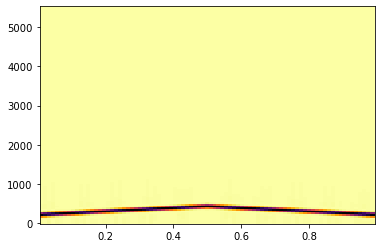

In [52]:
mychirp = TromboneGliss(start=220, end=440, amp=1.0)
mywave = mychirp.make_wave()
myspectrogram = mywave.make_spectrogram(256)
myspectrogram.plot()

In [56]:
mywave.apodize()
mywave.make_audio()

In [70]:
from thinkdsp import Audio, Wave
audio = Audio(data = np.random.normal(size = 10000), rate = 10012)
wave = Wave(np.random.normal(size = 10000), framerate = 10012)
wave.apodize()
wave.make_audio()